In [1]:
#%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster

In [47]:
df1 = pd.read_csv('Datasets/Original_data.csv')
df2 = pd.read_csv('Datasets/New_data.csv')


In [48]:
print("Original_data:Rows,Columns:"+str(df1.shape[0])+","+str(df1.shape[1])+"\nNew data:Rows,Columns:"+str(df2.shape[0])+","+str(df2.shape[1]))

Original_data:Rows,Columns:58,59
New data:Rows,Columns:58,41


In [49]:
df2.rename({'GEOID':'CountyID'},axis =1, inplace = True)
df = pd.merge(df1,df2, how="outer", on=["CountyID"])
df.head()

,CountyID,County,CountyFullName,State,DiabetesPercentage,DiabetesLowerLimit,DiabetesUpperLimit,Air Quality Value,Smoking%,RANK ORDER,...,Population Enrollment in - College,Population Enrollment in - College *margin of error,Population Enrollment in - Grad/Prof,Population Enrollment in - Grad/Prof *margin of error,Population Enrollment in - Elementary school (grades 1-8),Population Enrollment in - Elementary school (grades 1-8) *margin of error,Population Enrollment in - High school (grades 9-12),Population Enrollment in - High school (grades 9-12) *margin of error,Population Enrollment in - College or graduate school,Population Enrollment in - College or graduate school *margin of error
0,6001,Alameda,Alameda County,CA,7.4,5.7,9.5,166.9,166.9,9.0,...,102971.0,2561.0,32853.0,1668.0,149177.0,1232.0,76948.0,1144.0,135824.0,3093.0
1,6002,Alpine,Alpine County,CA,7.4,4.2,11.6,242.6,242.6,58.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6005,Amador,Amador County,CA,7.4,4.5,11.2,217.0,217.0,57.0,...,1980.0,353.0,182.0,112.0,2496.0,239.0,2252.0,281.0,2162.0,365.0
3,6007,Butte,Butte County,CA,6.7,4.1,9.9,224.6,224.6,45.0,...,22723.0,962.0,2665.0,404.0,19194.0,511.0,10793.0,448.0,25388.0,1007.0
4,6009,Calaveras,Calaveras County,CA,6.5,3.8,10.1,208.7,208.7,51.0,...,1796.0,316.0,100.0,77.0,3424.0,264.0,1812.0,234.0,1896.0,339.0


In [50]:
df.iloc[0,0:50]

CountyID                                                                                 6001
County                                                                                Alameda
CountyFullName                                                                 Alameda County
State                                                                                      CA
DiabetesPercentage                                                                        7.4
DiabetesLowerLimit                                                                        5.7
DiabetesUpperLimit                                                                        9.5
Air Quality Value                                                                       166.9
Smoking%                                                                                166.9
RANK ORDER                                                                                9.0
2019 POPULATION                                             

In [51]:
df.iloc[0,50:105]

Families-Mean income (dollars)                                                                                                              175733.0
latitude                                                                                                                                      37.745
longitude                                                                                                                                -122.154857
Total Enrollments                                                                                                                             1011.0
Healthcare_Utilization_Rate                                                                                                                 0.061326
Income_disparity_index                                                                                                                      1.247984
Population Demographics Ratio                                                                             

In [52]:
df_county = df[['CountyFullName','CountyID']]

### Defining Goal:

###### The classification of counties into clusters is justified by ensuring that counties within the same cluster exhibit a diverse age distribution, lower poverty rates, higher health insurance coverage, and healthier demographics. Optimal locations for family medicine services are identified based on these clusters, aligning with the specified goals of the use case. 

#### Removing Unccessary Columns:

In [53]:

unncessary_featues = ['County','CountyFullName','State','RANK ORDER','DiabetesLowerLimit',
'DiabetesUpperLimit','2019 POPULATION','2018-2020  DEATHS (TOTAL)','2018-2020  DEATHS (AVERAGE)',
'95% CONFIDENCE LIMIT (LOWER)','95% CONFIDENCE LIMIT (UPPER)','Cancer_Total',
'Female persons, percent','White alone, percent','Black or African American alone, percent',
'American Indian and Alaska Native alone, percent','Asian alone, percent',
'Native Hawaiian and Other Pacific Islander alone, percent','Two or More Races, percent',
'Hispanic or Latino, percent']
#Removing all the columns which has margin of error attached to it.
p = re.compile('.*\*margin of error$')
unncessary_featues += [x for x in df.columns if p.match(x)]
df.drop(unncessary_featues,axis = 1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 59 columns):
 #   Column                                                                                                                 Non-Null Count  Dtype  
---  ------                                                                                                                 --------------  -----  
 0   CountyID                                                                                                               59 non-null     int64  
 1   DiabetesPercentage                                                                                                     58 non-null     float64
 2   Air Quality Value                                                                                                      58 non-null     float64
 3   Smoking%                                                                                                               58 non-null     float64
 4   CRUD

#### Convert all columns to numeric.

In [54]:
Modify  = lambda u:[x if(type(x) == float) else x.split(' *')[0] for x in df[u].tolist()]
df['CRUDE DEATH RATE'] = pd.to_numeric(Modify('CRUDE DEATH RATE'))
df['AGE-ADJUSTED DEATH RATE'] = pd.to_numeric(Modify('AGE-ADJUSTED DEATH RATE'))

#### Domain Features:

In [55]:
domain_feature = [
    "CountyID","DiabetesPercentage", "Smoking%", 
    "Population Estimates, July 1 2021, (V2021)","CRUDE DEATH RATE", 
    "AGE-ADJUSTED DEATH RATE","Cancer_Rate_per_100K", "Persons under 18 years, percent", 
    "Persons 65 years and over, percent", 
    "Persons  without health insurance, under age 65 years, percent", 
    "Median household income (in 2021 dollars), 2017-2021","Total Cohabitating Couple Households",
    "Persons in poverty, percent","Income_disparity_index", "Population-Male", "Population-Female", 
    "Average Household Size", "Households w/Pop 65+ Living Alone", 
    "Total Households with one or more people 65 years and over",
    "Households: 1-Person Household with Pop 65+ (%)",
    "Percentage of Households - Male Householder, no spouse present, with own children of the householder under 18 years",
    "Percentage of Households - Female Householder, no spouse present, with own children of the householder under 18 years", 
    "Ethnic_Diversity_Index", "Education Diversity Score","SNF_Enrollment_ID_Count"
]
df = df[domain_feature]

### Correlation Matrix:

In [56]:
def corr_plot(x, y , z, title, height = 900, width = 900):
    trace = go.Figure(go.Heatmap(x=x,
                                 y=y,
                                 z=z,
                                 colorscale=px.colors.diverging.PRGn,
                                 zmin=-1,
                                 zmax=1,
                                ))
    trace.update_layout(title=title,
                        height = height, 
                        width = width,
                        font_color='#484848',
                       )
    trace.update_traces(text=z,
                        texttemplate="%{text:.2f}",
                        hovertemplate=None,
                       )
    return trace

In [57]:
df.corr().style.background_gradient(cmap='coolwarm')

,CountyID,DiabetesPercentage,Smoking%,"Population Estimates, July 1 2021, (V2021)",CRUDE DEATH RATE,AGE-ADJUSTED DEATH RATE,Cancer_Rate_per_100K,"Persons under 18 years, percent","Persons 65 years and over, percent","Persons without health insurance, under age 65 years, percent","Median household income (in 2021 dollars), 2017-2021",Total Cohabitating Couple Households,"Persons in poverty, percent",Income_disparity_index,Population-Male,Population-Female,Average Household Size,Households w/Pop 65+ Living Alone,Total Households with one or more people 65 years and over,Households: 1-Person Household with Pop 65+ (%),"Percentage of Households - Male Householder, no spouse present, with own children of the householder under 18 years","Percentage of Households - Female Householder, no spouse present, with own children of the householder under 18 years",Ethnic_Diversity_Index,Education Diversity Score,SNF_Enrollment_ID_Count
CountyID,1.000000,0.077380,-0.049498,-0.059524,-0.097666,-0.241618,-0.060036,0.032848,-0.035255,-0.139418,0.036118,-0.031718,-0.129513,-0.221164,-0.121101,-0.123126,0.024907,-0.028368,-0.026473,-0.080245,0.291930,-0.051315,0.037805,-0.059144,-0.079366
DiabetesPercentage,0.077380,1.000000,0.178105,0.266299,-0.542398,-0.439695,-0.293043,0.616620,-0.724243,0.158779,0.031436,0.270040,0.217323,-0.607865,0.196741,0.191781,0.678794,0.239634,0.248526,-0.644349,0.066987,0.621242,-0.121009,0.202906,0.185414
Smoking%,-0.049498,0.178105,1.000000,-0.083196,0.367508,0.401914,0.338711,0.336441,0.002583,0.414470,-0.775921,-0.077976,0.705494,-0.402421,-0.007192,-0.007489,0.088984,-0.126927,-0.112197,0.095724,0.407033,0.444667,-0.207527,-0.718348,-0.050658
"Population Estimates, July 1 2021, (V2021)",-0.059524,0.266299,-0.083196,1.000000,-0.322625,-0.297700,-0.314042,0.053101,-0.321214,0.074059,0.196800,0.995183,-0.153021,-0.215784,0.999953,0.999954,0.191850,0.994505,0.998024,-0.360088,-0.141100,0.060486,0.154816,0.337779,0.928915
CRUDE DEATH RATE,-0.097666,-0.542398,0.367508,-0.322625,1.000000,0.846879,0.443231,-0.537304,0.786310,-0.057898,-0.434381,-0.313686,0.285924,0.468944,-0.297140,-0.293662,-0.568204,-0.318145,-0.317184,0.716239,0.314255,-0.395575,0.137909,-0.652278,-0.221941
AGE-ADJUSTED DEATH RATE,-0.241618,-0.439695,0.401914,-0.297700,0.846879,1.000000,0.494876,-0.451579,0.657092,0.085906,-0.307123,-0.337356,0.290143,0.398404,-0.305240,-0.302236,-0.621268,-0.346050,-0.344256,0.683103,0.246527,-0.376610,0.178101,-0.500587,-0.204997
Cancer_Rate_per_100K,-0.060036,-0.293043,0.338711,-0.314042,0.443231,0.494876,1.000000,-0.108765,0.343549,0.028690,-0.427229,-0.274690,0.216198,0.162069,-0.275425,-0.272389,-0.267494,-0.288577,-0.288289,0.336546,-0.061189,-0.053687,0.102785,-0.619984,-0.191883
"Persons under 18 years, percent",0.032848,0.616620,0.336441,0.053101,-0.537304,-0.451579,-0.108765,1.000000,-0.759019,0.446014,-0.258102,0.018853,0.283461,-0.685564,-0.054103,-0.056506,0.830006,-0.011414,0.006770,-0.588994,0.068299,0.868395,-0.509981,-0.089970,-0.014242
"Persons 65 years and over, percent",-0.035255,-0.724243,0.002583,-0.321214,0.786310,0.657092,0.343549,-0.759019,1.000000,-0.168078,-0.199359,-0.301802,0.000138,0.719727,-0.249182,-0.243475,-0.779893,-0.285176,-0.290371,0.880036,0.205542,-0.666934,0.160512,-0.403403,-0.204608
"Persons without health insurance, under age 65 years, percent",-0.139418,0.158779,0.414470,0.074059,-0.057898,0.085906,0.028690,0.446014,-0.168078,1.000000,-0.507400,0.091659,0.461937,-0.430499,0.142914,0.141571,0.390350,0.053378,0.067274,0.010098,0.118367,0.507860,-0.562458,-0.281168,0.088482


###### We are removing columns which are more correlated.

In [58]:
highly_corelated_feature = ["Total Cohabitating Couple Households","Population-Male", "Population-Female","Households w/Pop 65+ Living Alone","Total Households with one or more people 65 years and over"]
df.drop(highly_corelated_feature,axis = 1,inplace=True)

###### We are removing columns which have more than 25% missing values and fill the reaming columns missing data.

In [59]:
df.isnull().sum() * 100 / len(df)

CountyID                                                                                                                  0.000000
DiabetesPercentage                                                                                                        1.694915
Smoking%                                                                                                                  1.694915
Population Estimates, July 1 2021, (V2021)                                                                               10.169492
CRUDE DEATH RATE                                                                                                          1.694915
AGE-ADJUSTED DEATH RATE                                                                                                   1.694915
Cancer_Rate_per_100K                                                                                                      8.474576
Persons under 18 years, percent                                                    

In [60]:
df.drop(["Income_disparity_index"],axis = 1,inplace=True)
mean_imputer = SimpleImputer(strategy='mean')
df.iloc[:,:] = mean_imputer.fit_transform(df)
df.isnull().sum()

CountyID                                                                                                                 0
DiabetesPercentage                                                                                                       0
Smoking%                                                                                                                 0
Population Estimates, July 1 2021, (V2021)                                                                               0
CRUDE DEATH RATE                                                                                                         0
AGE-ADJUSTED DEATH RATE                                                                                                  0
Cancer_Rate_per_100K                                                                                                     0
Persons under 18 years, percent                                                                                          0
Persons 65 years

# Clustering:

### K-Means Clustering:

In [61]:
std_scaler = StandardScaler()
std_scaler.fit(df)
df1 = pd.DataFrame(std_scaler.transform(df), columns=df.columns)
df1.head()

,CountyID,DiabetesPercentage,Smoking%,"Population Estimates, July 1 2021, (V2021)",CRUDE DEATH RATE,AGE-ADJUSTED DEATH RATE,Cancer_Rate_per_100K,"Persons under 18 years, percent","Persons 65 years and over, percent","Persons without health insurance, under age 65 years, percent","Median household income (in 2021 dollars), 2017-2021","Persons in poverty, percent",Average Household Size,Households: 1-Person Household with Pop 65+ (%),"Percentage of Households - Male Householder, no spouse present, with own children of the householder under 18 years","Percentage of Households - Female Householder, no spouse present, with own children of the householder under 18 years",Ethnic_Diversity_Index,Education Diversity Score,SNF_Enrollment_ID_Count
0,-1.649802,-0.471767,-1.100390,0.649063,-0.915787,-0.863609,-6.755398e-01,-5.071762e-01,-0.738073,-1.604161e+00,1.563905e+00,-1.109843e+00,7.673955e-02,-0.815295,-4.750593e-01,-0.427674,1.989776,1.739483e+00,0.399967
1,-1.620368,-0.471767,1.098087,-0.524755,1.707687,5.027153,-6.871684e-16,-1.119212e+00,1.204463,1.693570e+00,8.388202e-01,6.548766e-01,-1.317729e-15,0.000000,3.169996e-16,0.000000,1.224690,1.777925e-01,-0.284328
2,-1.532066,-0.471767,0.354612,-0.496236,2.431404,2.099623,2.448205e+00,-1.870346e+00,1.714624,-7.932436e-01,-3.402299e-01,-6.410897e-01,-1.228856e+00,1.379852,-1.474407e+00,-1.648651,-0.102882,-1.633769e+00,-0.253129
3,-1.473198,-1.101825,0.575331,-0.377202,0.725499,0.719161,3.399190e-01,-4.237168e-01,-0.090561,-3.607543e-01,-7.970920e-01,8.754666e-01,-9.321297e-01,0.038373,-4.750593e-01,0.022159,0.208986,-4.572951e-01,-0.247583
4,-1.414330,-1.281841,0.113564,0.000000,1.268287,0.980973,4.978793e-02,-7.721543e-16,0.000000,1.500499e-15,6.587613e-16,-7.653253e-16,-3.683498e-01,0.404231,2.387604e-01,-0.877508,0.000000,1.479531e-13,-0.278089


In [62]:
counties = len(df1.columns)
pca = PCA(n_components=counties)
pca_fit = pca.fit(df1)
PC_values = np.arange(counties) + 1
var_ratio = pca.explained_variance_ratio_
pca_colnames = ['PCA_%s' % i for i in PC_values]
marketing_pca_df = pd.DataFrame(pca.transform(df1), 
                                columns=(pca_colnames), 
                                index=df1.index)

In [63]:
fpca = 0
perc = np.zeros(shape=counties)
for i in range(counties):
    fpca += var_ratio[i] * 100
    perc[i] = fpca

In [64]:
var_ratio_df = pd.DataFrame([var_ratio, perc], columns=pca_colnames)
var_ratio_df

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19
0,0.312600,0.251489,0.096174,0.071484,0.060307,0.047689,0.031726,0.026616,0.020126,0.016931,0.015129,0.013119,0.010229,0.008918,0.006365,0.005149,0.002773,0.001870,0.001305
1,31.260012,56.408917,66.026285,73.174713,79.205463,83.974365,87.146983,89.808625,91.821244,93.514304,95.027246,96.339099,97.361972,98.253766,98.890224,99.405155,99.682431,99.869462,100.000000


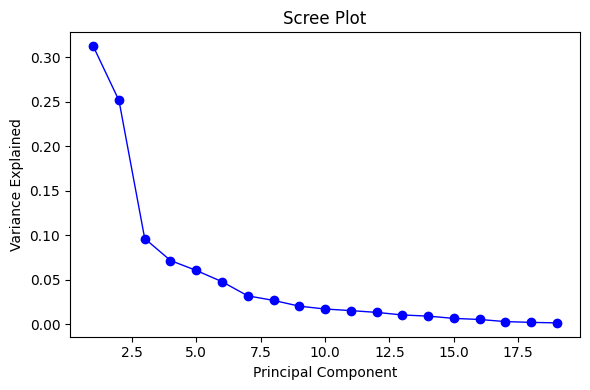

In [100]:
plt.plot(PC_values, var_ratio, 'o-', linewidth=1, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

###### Looks like the best K value is 3 or 4.

#### Model Implementation:

In [101]:
AC = KMeans(n_clusters=4)
AC_clust = AC.fit_predict(df1)

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


([<matplotlib.patches.Wedge at 0x7f01369dca90>,
 [Text(1.0984409652386318, 0.05854439243534087, 'Group_1'),
  Text(0.37316274431421964, 1.0347702963730068, 'Group_2'),
  Text(-1.0612446436976029, -0.28941286464694066, 'Group_3'),
  Text(0.6792771205481619, -0.8652066767540563, 'Group_4')])

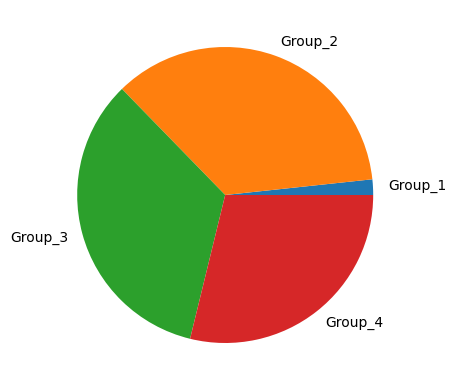

In [102]:
df1['Clusters_k'] = AC_clust
df1['Clusters_group'] = df1['Clusters_k'].replace({0:'Group_1',1:'Group_2',2:'Group_3',3:'Group_4'})
#Adding the Clusters feature to the orignal dataframe.
df['Clusters_k'] = AC_clust
df['Clusters_group'] = df['Clusters_k'].replace({0:'Group_1',1:'Group_2',2:'Group_3',3:'Group_4'})

cluster_count = df.sort_values('Clusters_group')['Clusters_group'].value_counts().sort_index()
df.drop(["Clusters_group"],axis = 1,inplace=True)
df1.drop(["Clusters_group"],axis = 1,inplace=True)
plt.pie(cluster_count.values, labels = cluster_count.index)

In [103]:
AC = KMeans(n_clusters=3)
AC_clust = AC.fit_predict(df1)

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


([<matplotlib.patches.Wedge at 0x7f0139bd29b0>,
 [Text(0.5330059329343616, 0.962239406518342, 'Group_1'),
  Text(-1.0859951829743537, -0.17496989042832478, 'Group_2'),
  Text(0.6792770901707258, -0.8652067006034986, 'Group_3')])

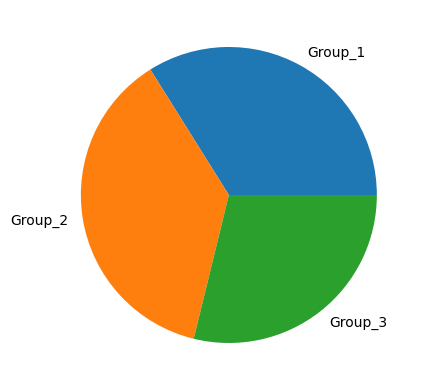

In [104]:
df1['Clusters_k'] = AC_clust
df1['Clusters_group'] = df1['Clusters_k'].replace({0:'Group_1',1:'Group_2',2:'Group_3'})
#Adding the Clusters feature to the orignal dataframe.
df['Clusters_k'] = AC_clust
df['Clusters_group'] = df['Clusters_k'].replace({0:'Group_1',1:'Group_2',2:'Group_3'})

cluster_count = df.sort_values('Clusters_group')['Clusters_group'].value_counts().sort_index()
df.drop(["Clusters_group"],axis = 1,inplace=True)
df1.drop(["Clusters_group"],axis = 1,inplace=True)
plt.pie(cluster_count.values, labels = cluster_count.index)

## Hierarchical Clustering:

#### Plotting a Dendrogram:

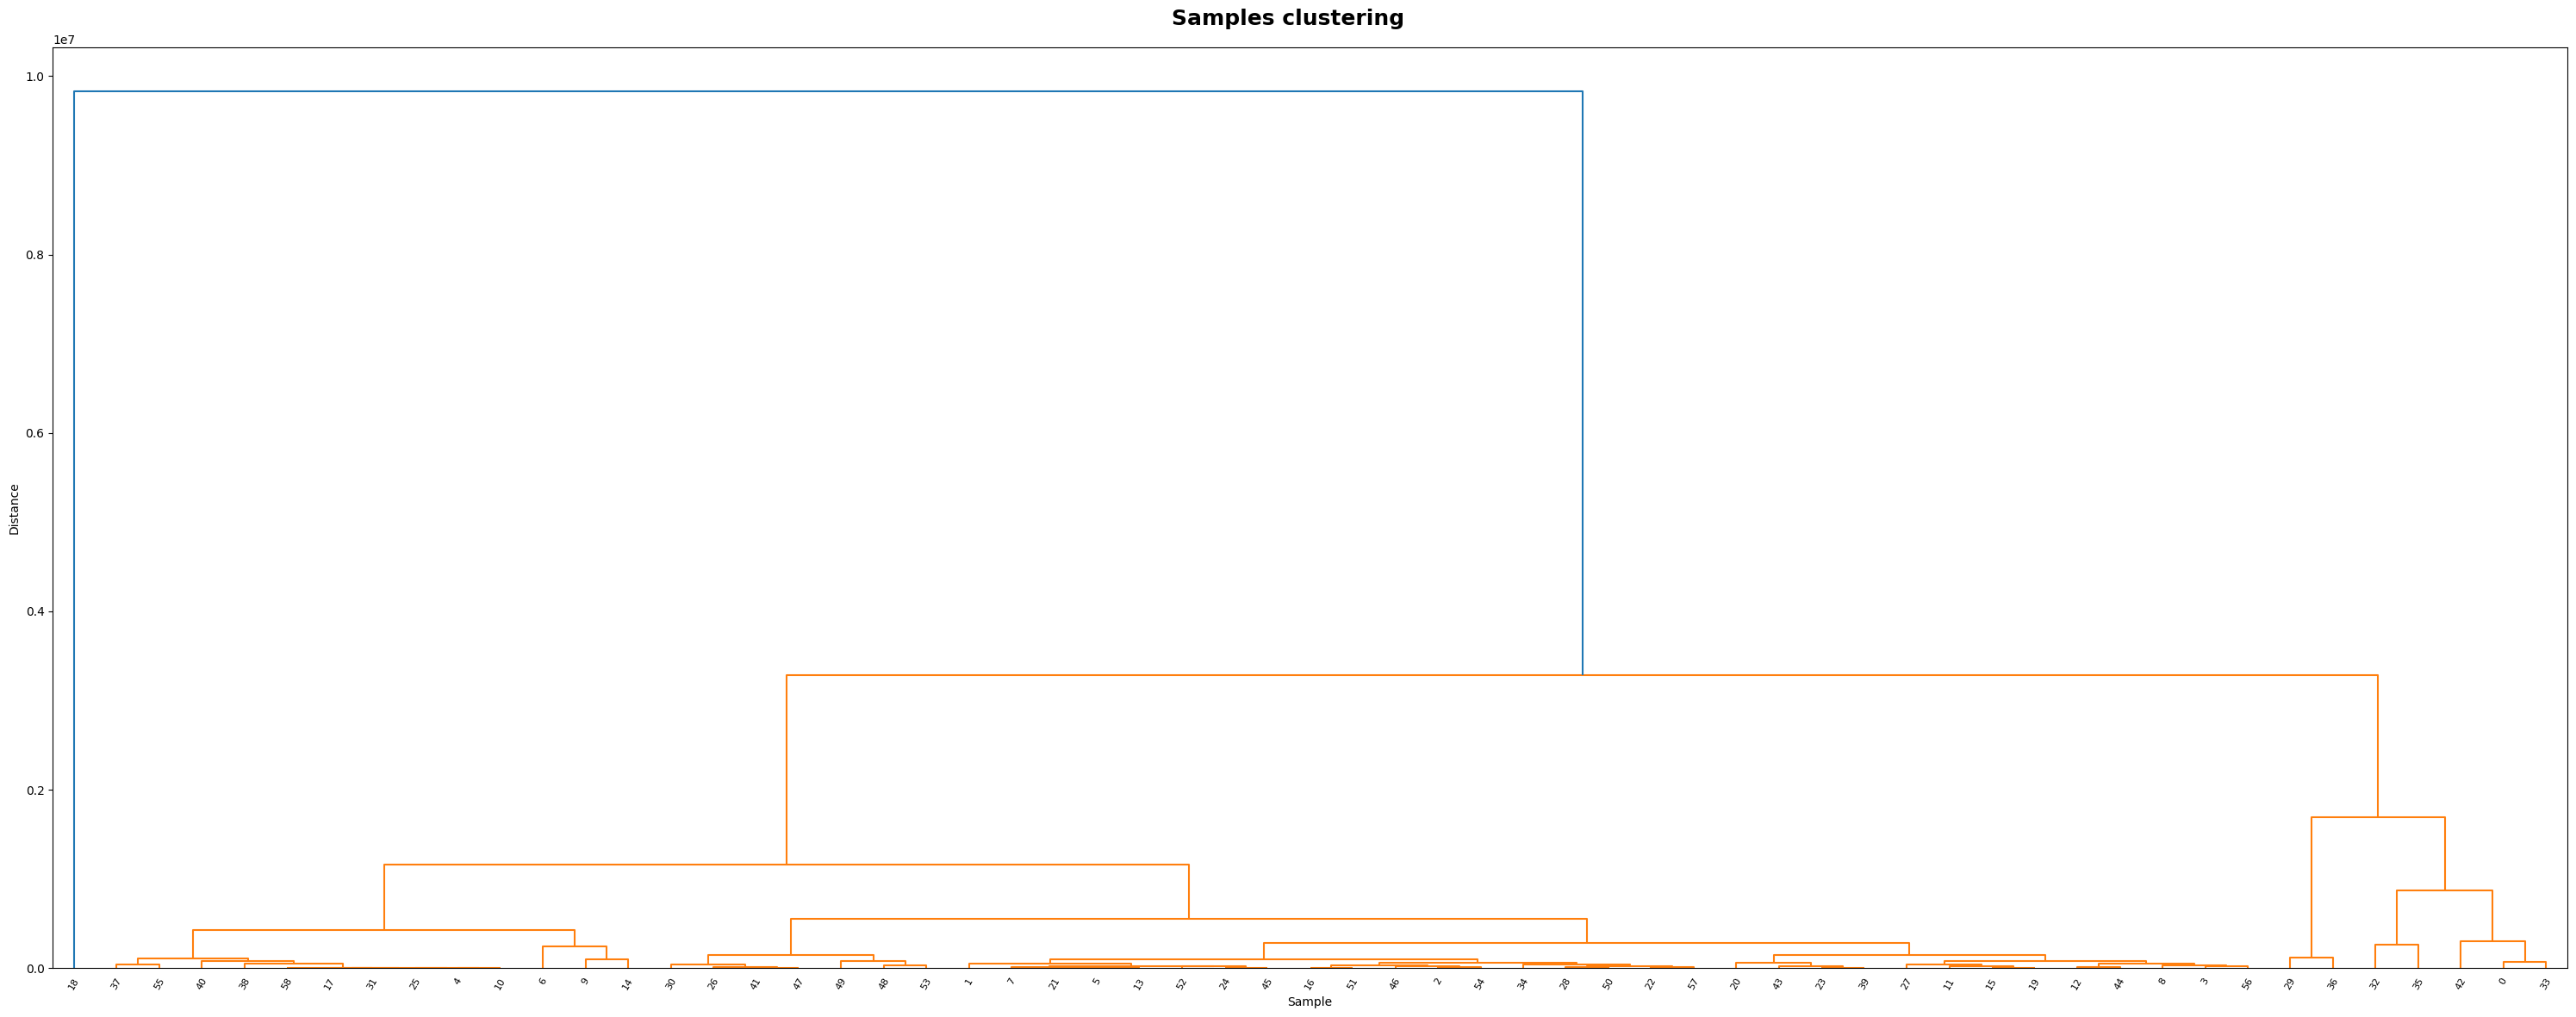

In [70]:
#Genrating Linkage Matrix
data_link_c = linkage(df, 'complete')

plt.rcParams['figure.figsize'] = (30, 12)
dendrogram(data_link_c, labels=df.index, leaf_rotation=60.0, leaf_font_size=8.)
plt.xlabel('Sample')
plt.ylabel('Distance')
plt.suptitle('Samples clustering', fontweight='bold', fontsize=18);

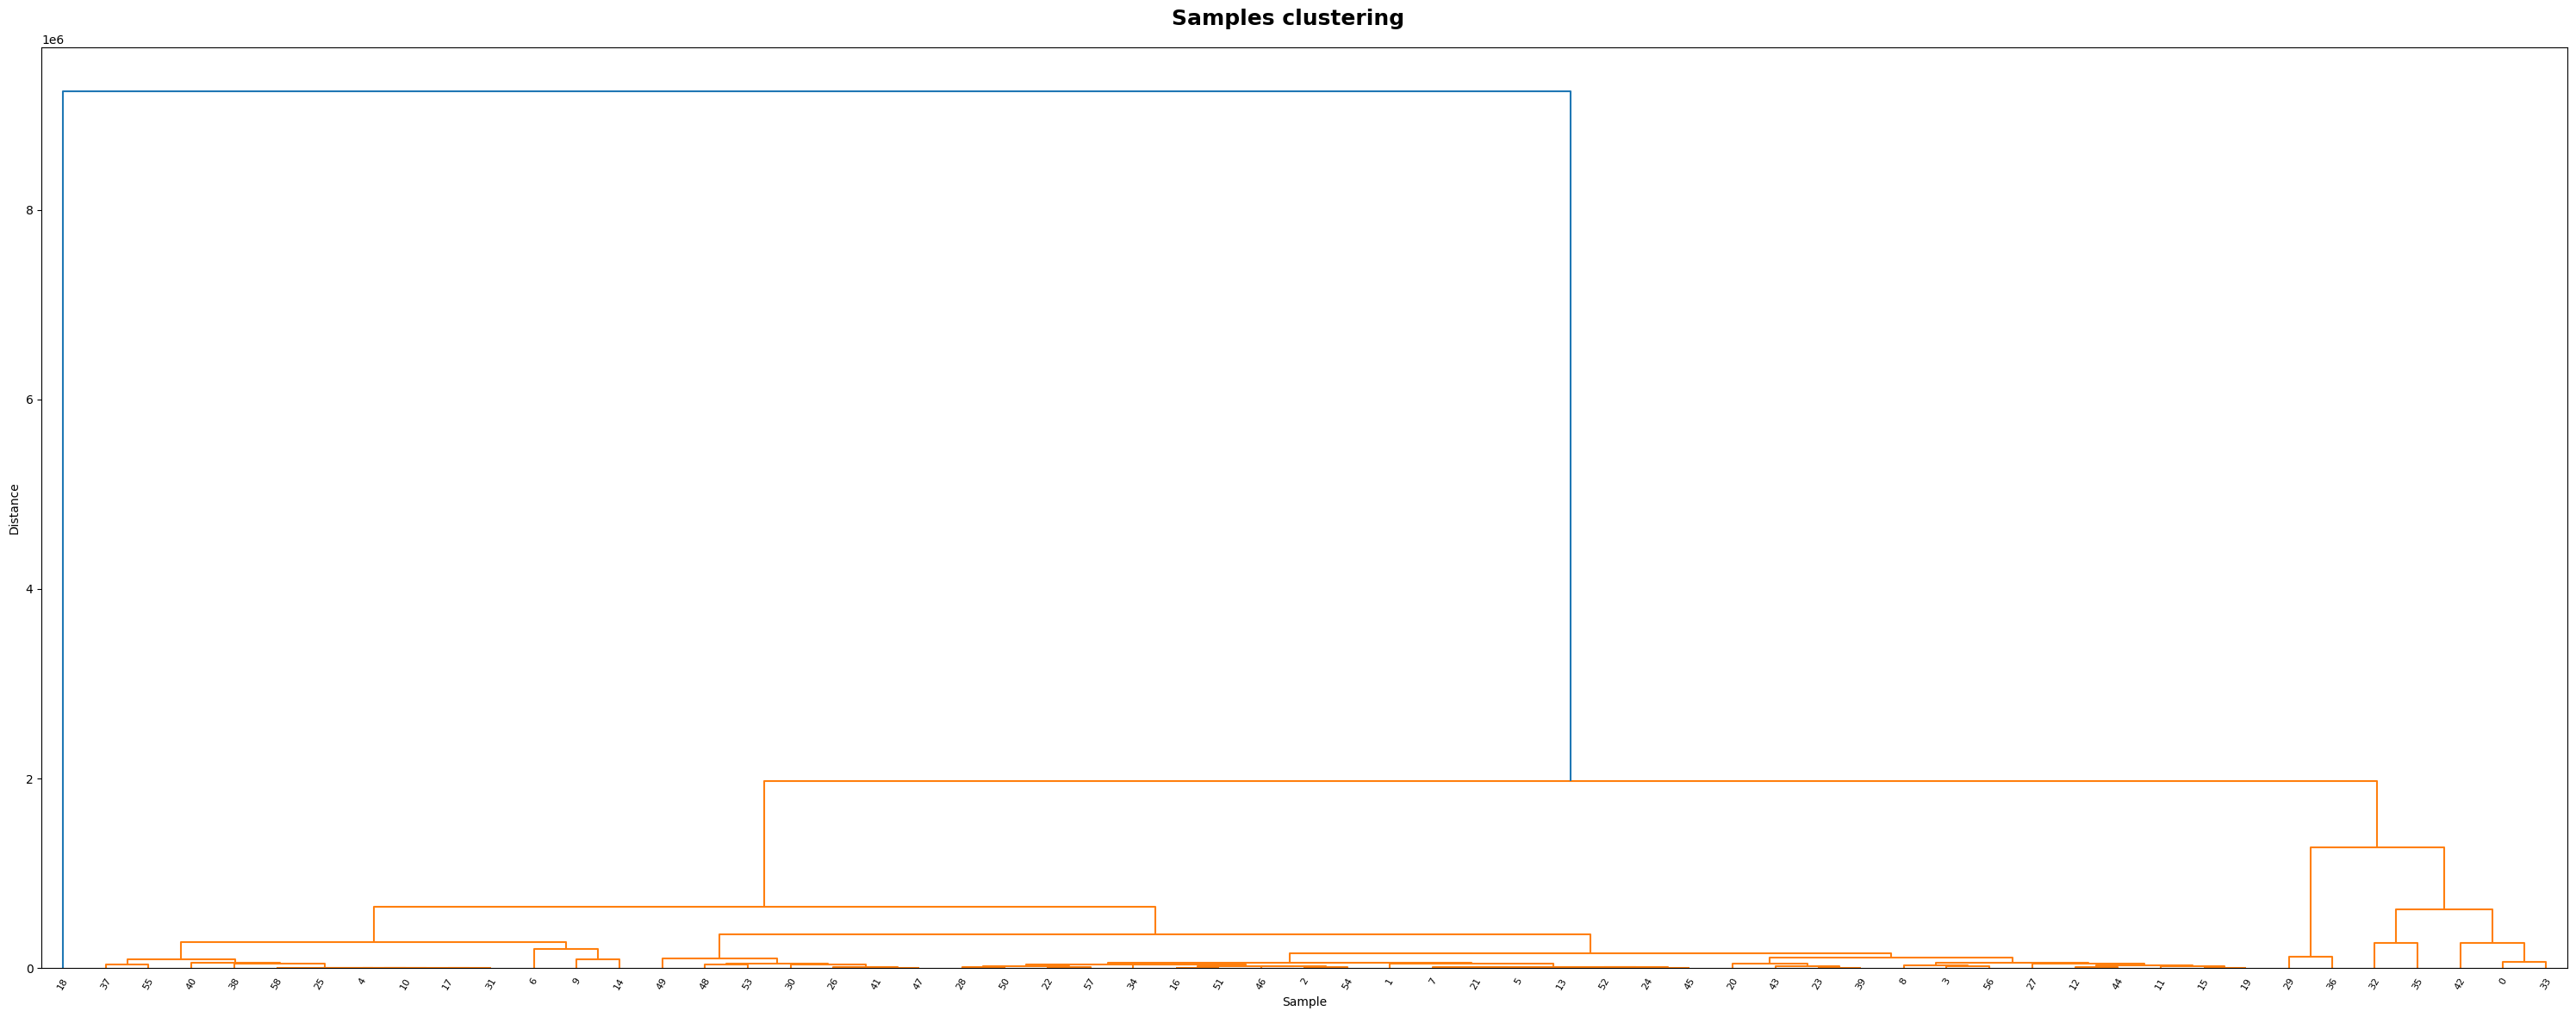

In [71]:
#Genrating Linkage Matrix
data_link_a = linkage(df, 'average')

plt.rcParams['figure.figsize'] = (30, 12)
dendrogram(data_link_a, labels=df.index, leaf_rotation=60.0, leaf_font_size=8.)
plt.xlabel('Sample')
plt.ylabel('Distance')
plt.suptitle('Samples clustering', fontweight='bold', fontsize=18);

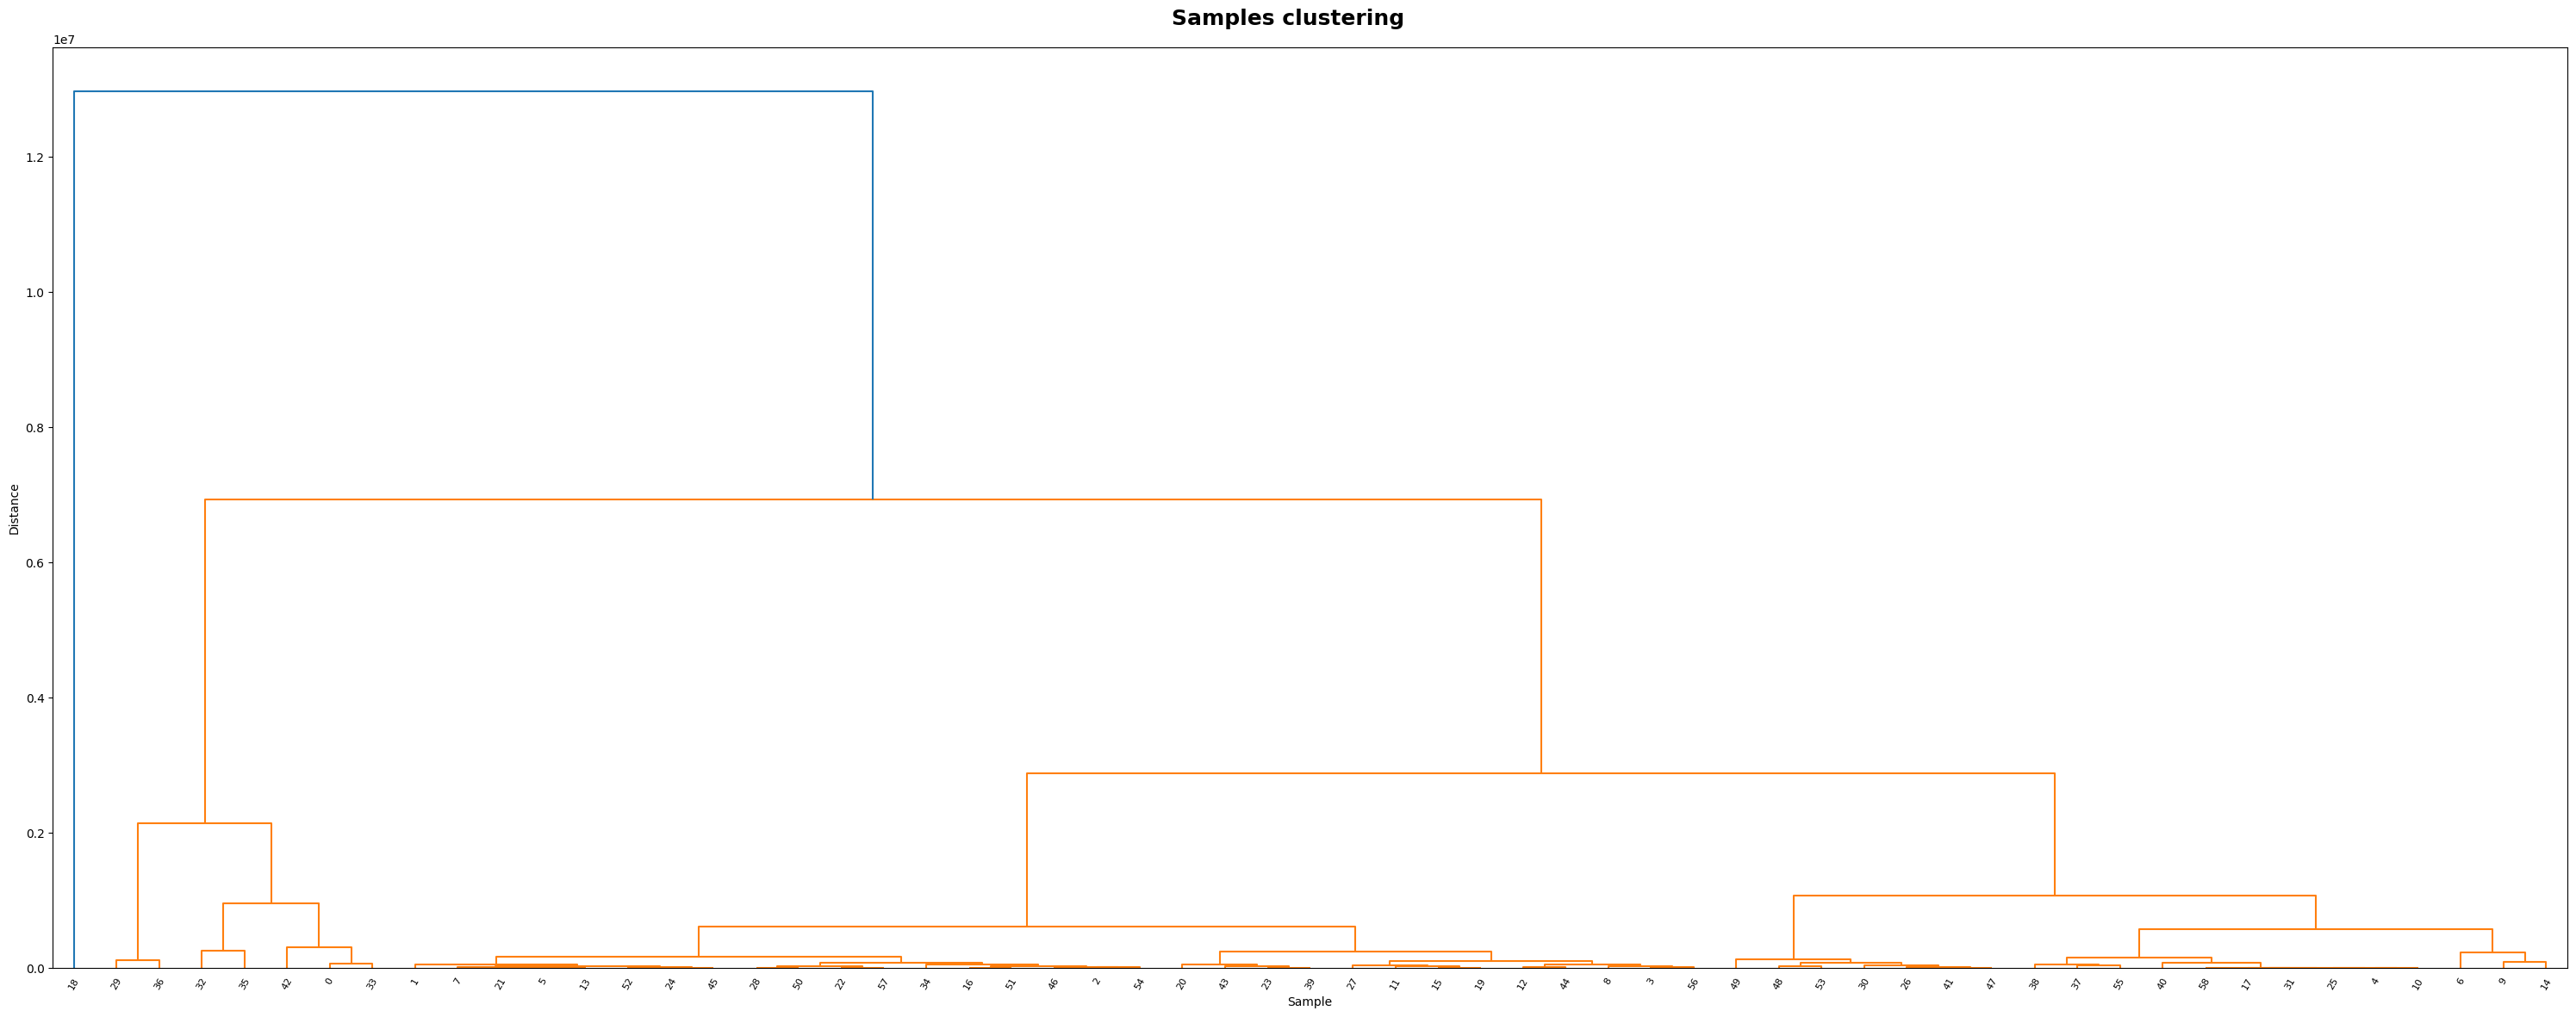

In [72]:
#Genrating Linkage Matrix
data_link_w = linkage(df, 'ward')
plt.rcParams['figure.figsize'] = (30, 12)
dendrogram(data_link_w, labels=df.index, leaf_rotation=60.0, leaf_font_size=8.)
plt.xlabel('Sample')
plt.ylabel('Distance')
plt.suptitle('Samples clustering', fontweight='bold', fontsize=18);

###### As we can see ward linkage is the best meathod. 

In [73]:
data_link = data_link_w

#### Truncating and Set Distance Cutoff for Dendrogram:

In [74]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

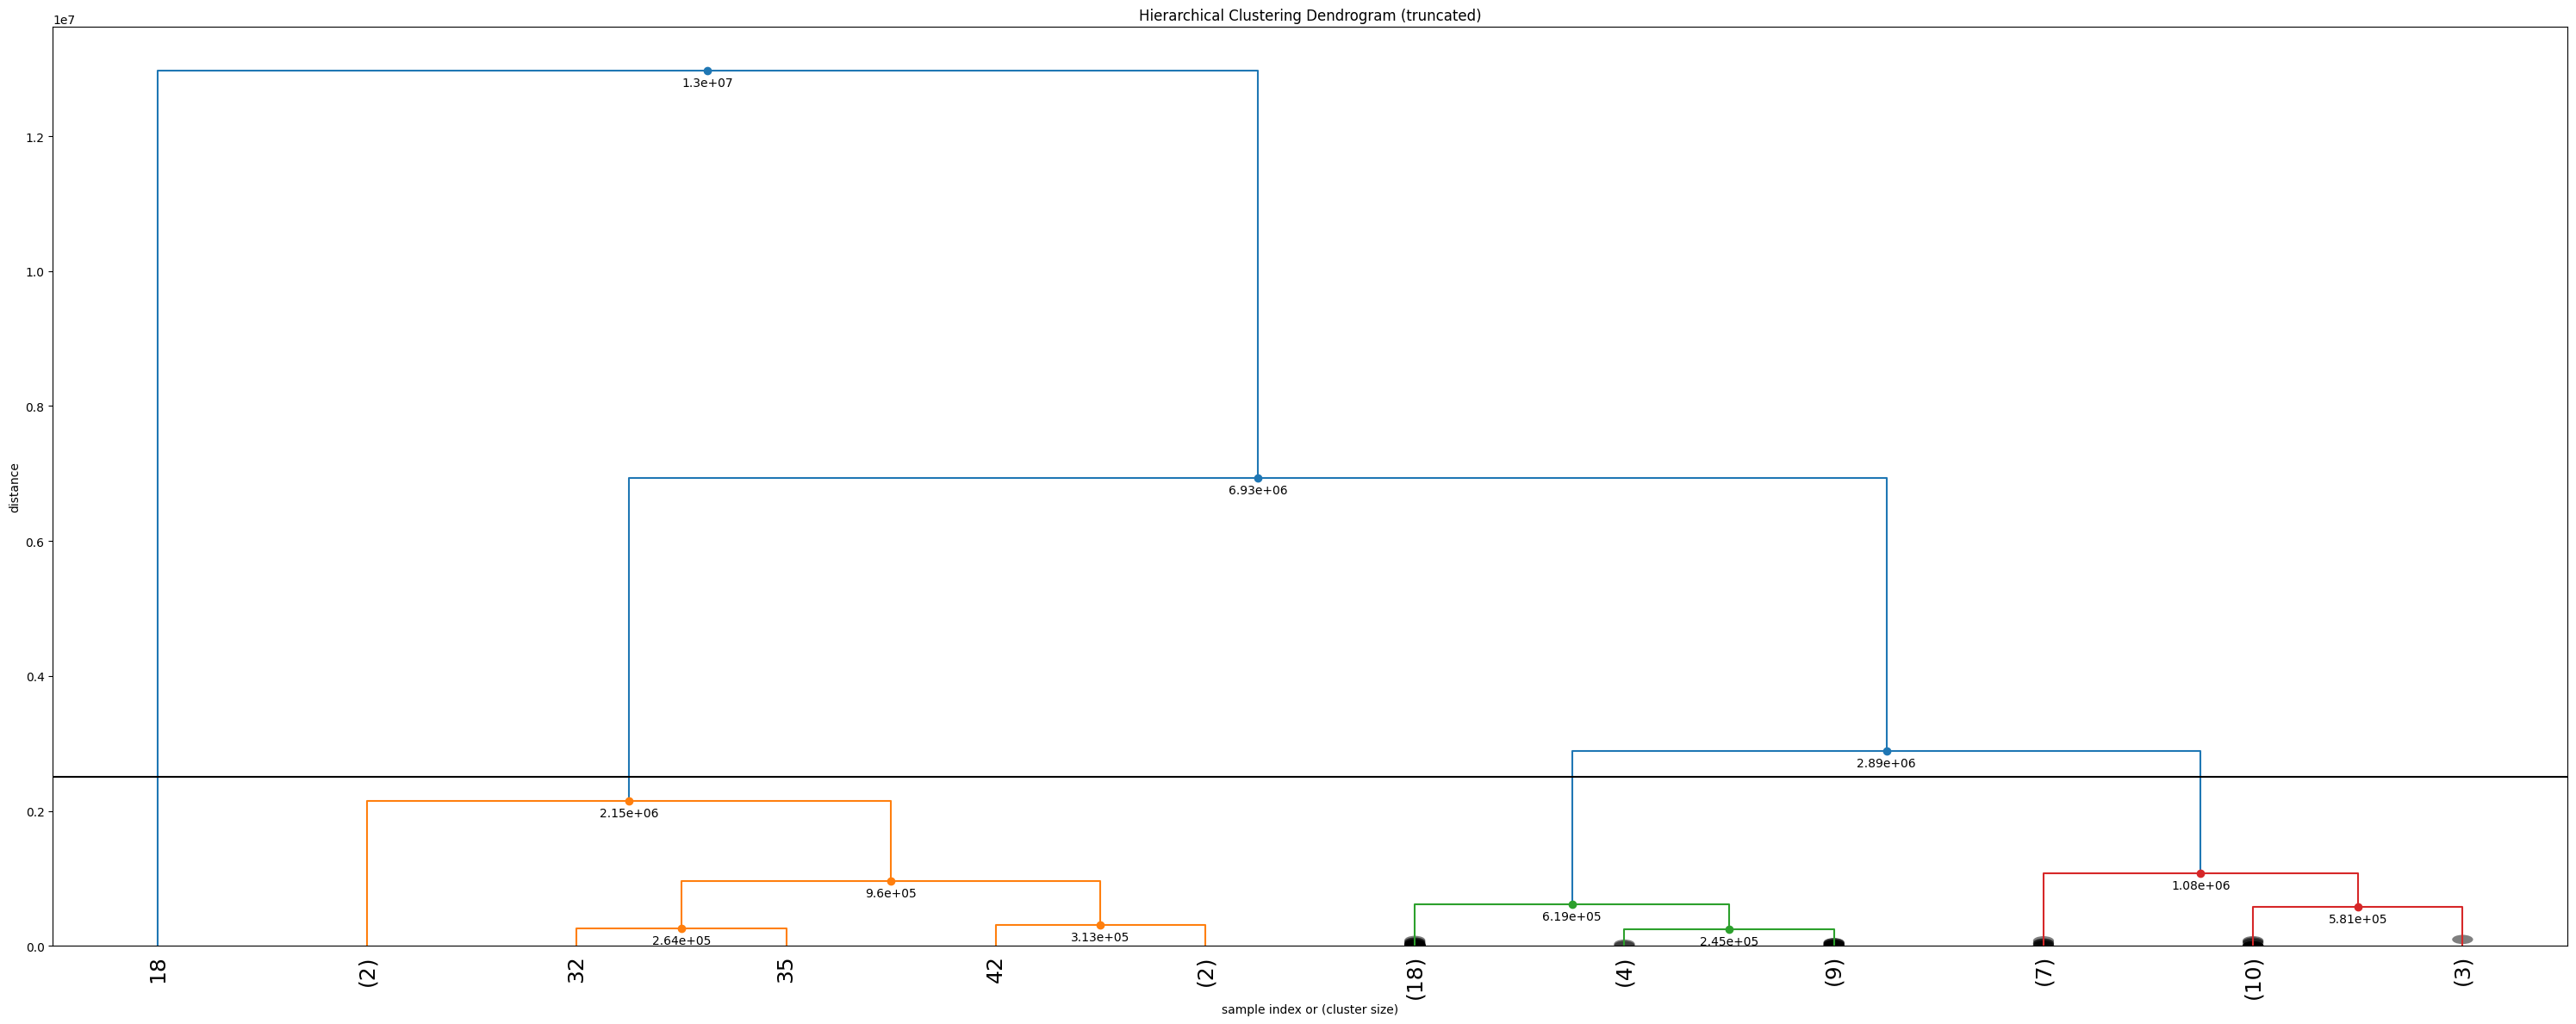

In [75]:
max_d = 0.25*1e7
fancy_dendrogram(
    data_link,
    truncate_mode='lastp',p=12,
    leaf_rotation=90.,leaf_font_size=18.,
    show_contracted=True,max_d=max_d,  # plot a horizontal cut-off line
)
plt.show()

###### Here we are getting 3 Clusters. 

In [76]:
max_d = 0.25*1e7
df['Clusters_c'] = fcluster(data_link, max_d, criterion='distance')
print(df['Clusters_c'].tolist())

[1, 2, 2, 2, 3, 2, 3, 2, 2, 3, 3, 2, 2, 2, 3, 2, 2, 3, 4, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 1, 3, 3, 1, 1, 2, 1, 1, 3, 3, 2, 3, 3, 1, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 3, 2, 3, 2, 2, 3]


([<matplotlib.patches.Wedge at 0x7f0136e364d0>,
 [Text(1.0244697972635088, 0.40057662749449763, 'Group_1'),
  Text(-0.8082515037867449, 0.7461430872335852, 'Group_2'),
  Text(0.4277064603419144, -1.013443231652267, 'Group_3'),
  Text(1.098440959072139, -0.05854450813423943, 'Group_4')])

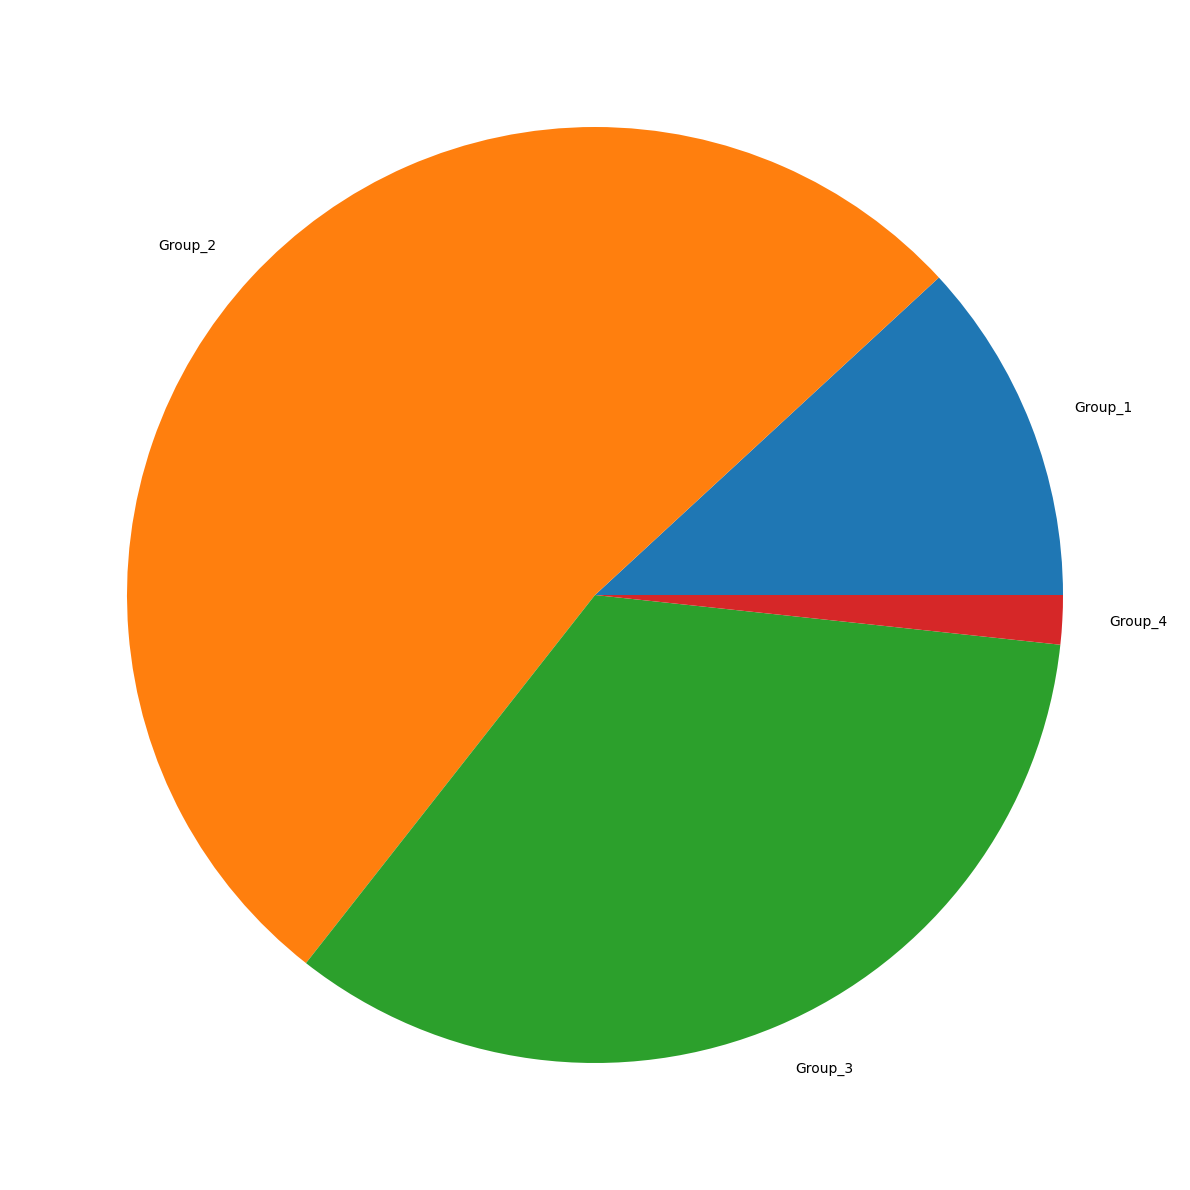

In [77]:
df['Clusters_group'] = df['Clusters_c'].replace({1:'Group_1',2:'Group_2',3:'Group_3',4:'Group_4'})
cluster_count = df.sort_values('Clusters_group')['Clusters_group'].value_counts().sort_index()

df.drop(["Clusters_group"],axis = 1,inplace=True)
plt.pie(cluster_count.values, labels = cluster_count.index)

## Distribution of Clusters:

### K-means Map Chart:

##### Graph 1:

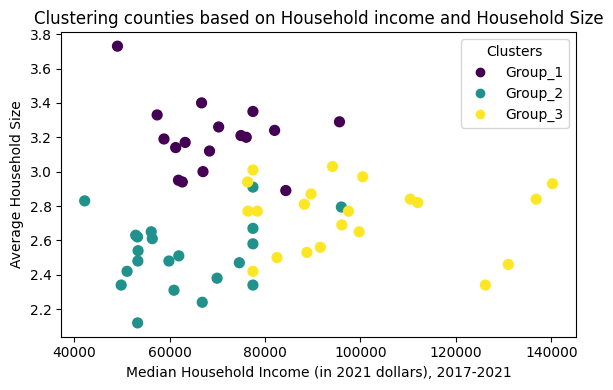

In [78]:
plt.rcParams["figure.figsize"] = [6.00, 4.00]
plt.rcParams["figure.autolayout"] = True
x = df['Median household income (in 2021 dollars), 2017-2021'].values
y = df['Average Household Size'].values
Cluster = df['Clusters_k'].values
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(x, y, c=Cluster, s=50)
labels1 = ['Group_1','Group_2','Group_3']
handles = scatter.legend_elements()[0]
ax.legend(title="Clusters", handles=handles, labels = labels1)

plt.xlabel("Median Household Income (in 2021 dollars), 2017-2021")
plt.ylabel("Average Household Size")
plt.title("Clustering counties based on Household income and Household Size")
plt.show()

##### Graph 2:

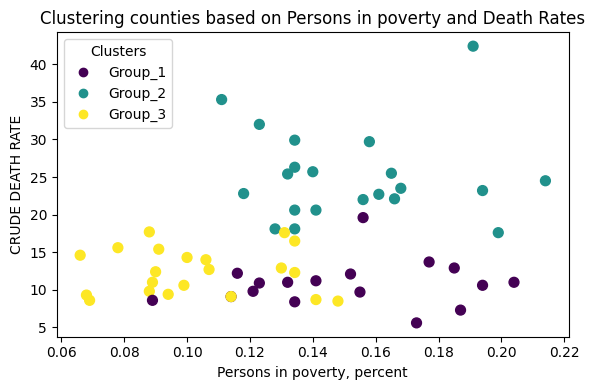

In [79]:
plt.rcParams["figure.figsize"] = [6.00, 4.00]
plt.rcParams["figure.autolayout"] = True

x = df['Persons in poverty, percent'].values
y = df['CRUDE DEATH RATE'].values
Cluster = df['Clusters_k'].values

fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(x, y, c=Cluster, s=50)

labels1 = ['Group_1','Group_2','Group_3']
handles = scatter.legend_elements()[0]
ax.legend(title="Clusters", handles=handles, labels = labels1)

plt.xlabel("Persons in poverty, percent")
plt.ylabel("CRUDE DEATH RATE")
plt.title("Clustering counties based on Persons in poverty and Death Rates")
plt.show()

##### Graph 3:

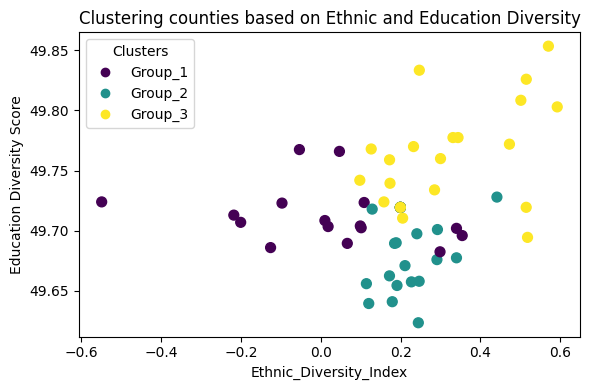

In [80]:
plt.rcParams["figure.figsize"] = [6.00, 4.00]
plt.rcParams["figure.autolayout"] = True

x = df['Ethnic_Diversity_Index']
y = df['Education Diversity Score']
Cluster = df['Clusters_k'].values

fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(x, y, c=Cluster, s=50)

labels1 = ['Group_1','Group_2','Group_3']
handles = scatter.legend_elements()[0]
ax.legend(title="Clusters", handles=handles, labels = labels1)

plt.xlabel("Ethnic_Diversity_Index")
plt.ylabel("Education Diversity Score")
plt.title("Clustering counties based on Ethnic and Education Diversity")
plt.show()

#### Summary of K-Means Model Result:

###### From observing all the graphs can describe each Group in following manner:
###### Group 1:
###### - Graph 1: Low Income, Less Household Size
###### - Graph 2: High Poverty, High Death rate
###### - Graph 3: Less Educational Diversity, Medium Ethnic Diversity
###### 
###### Group 2:
###### - Graph 1: Medium to High Income, Less Household Size
###### - Graph 2: Medium to Low Poverty, Less Death rate
###### - Graph 3: High Educational Diversity, Medium to High Ethnic Diversity
###### 
###### Group 3:
###### - Graph 1: Medium to High Income, High Household Size
###### - Graph 2: Medium to High Poverty, Less Death rate
###### - Graph 3: Medium Educational Diversity, Medium to Low Ethnic Diversity

###### From these observations we can produce some hypothesis on each group as follows:
###### 1. We can say that Group 1 has counties which as low on Social, Demographic and Health indicator.
###### 2. We can say that Group 2 has counties which as High on Social, Demographic and Health indicator excluding the family size.
###### 3. We can say that Group 3 has counties more Isolated with High Household Size and Medium to Low Ethnic Diversity, Medium to High Poverty and Less Death rate.

##### Using these details we can pick the best county group to our expand family medicine services. The Counties in each group are as follows:

In [99]:
dfc = pd.merge(df_county,df[['CountyID','Clusters_k']], how="outer", on=["CountyID"]).drop(['CountyID'],axis=1)
dfc['Clusters_k'] = dfc['Clusters_k'].replace({0:'Group_1',1:'Group_2',2:'Group_3'})
dfc.groupby(['Clusters_k','CountyFullName']).count()

Empty DataFrame
Columns: []
Index: [(Group_1, Colusa County), (Group_1, Fresno County), (Group_1, Imperial County), (Group_1, Kern County), (Group_1, Kings County), (Group_1, Madera County), (Group_1, Merced County), (Group_1, Monterey County), (Group_1, Riverside County), (Group_1, San Benito County), (Group_1, San Bernardino County), (Group_1, San Joaquin County), (Group_1, Santa Barbara County), (Group_1, Stanislaus County), (Group_1, Sutter County), (Group_1, Tulare County), (Group_1, Yuba County), (Group_2, Alpine County), (Group_2, Amador County), (Group_2, Butte County), (Group_2, Calaveras County), (Group_2, Del Norte County), (Group_2, Glenn County), (Group_2, Humboldt County), (Group_2, Inyo County), (Group_2, Lake County), (Group_2, Lassen County), (Group_2, Mariposa County), (Group_2, Mendocino County), (Group_2, Modoc County), (Group_2, Nevada County), (Group_2, Plumas County), (Group_2, Shasta County), (Group_2, Sierra County), (Group_2, Siskiyou County), (Group_2, Tehama County), (Group_2, Trinity County), (Group_2, Tuolumne County), (Group_3, Alameda County), (Group_3, Contra Costa County), (Group_3, El Dorado County), (Group_3, Los Angeles County), (Group_3, Marin County), (Group_3, Mono County), (Group_3, Napa County), (Group_3, Orange County), (Group_3, Placer County), (Group_3, Sacramento County), (Group_3, San Diego County), (Group_3, San Francisco County), (Group_3, San Luis Obispo County), (Group_3, San Mateo County), (Group_3, Santa Clara County), (Group_3, Santa Cruz County), (Group_3, Solano County), (Group_3, Sonoma County), (Group_3, Ventura County), (Group_3, Yolo County)]

### Hierarchical Clustering Map Chart:

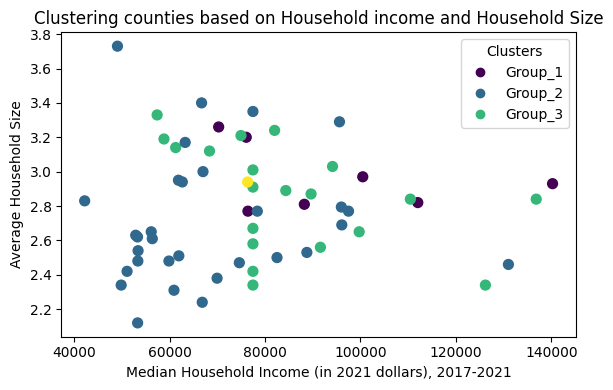

In [81]:
x = df['Median household income (in 2021 dollars), 2017-2021'].values
y = df['Average Household Size'].values
Cluster = df['Clusters_c'].values

fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(x, y, c=Cluster, s=50)

labels1 = ['Group_1','Group_2','Group_3']
handles = scatter.legend_elements()[0]
ax.legend(title="Clusters", handles=handles, labels = labels1)

plt.xlabel("Median Household Income (in 2021 dollars), 2017-2021")
plt.ylabel("Average Household Size")
plt.title("Clustering counties based on Household income and Household Size")
plt.show()

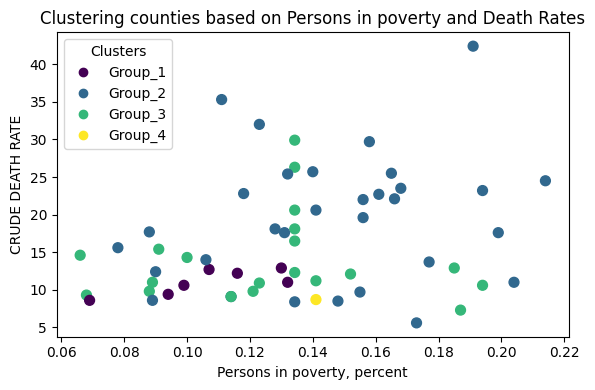

In [82]:
plt.rcParams["figure.figsize"] = [6.00, 4.00]
plt.rcParams["figure.autolayout"] = True

x = df['Persons in poverty, percent'].values
y = df['CRUDE DEATH RATE'].values
Cluster = df['Clusters_c'].values

fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(x, y, c=Cluster, s=50)

labels1 = ['Group_1','Group_2','Group_3','Group_4']
handles = scatter.legend_elements()[0]
ax.legend(title="Clusters", handles=handles, labels = labels1)

plt.xlabel("Persons in poverty, percent")
plt.ylabel("CRUDE DEATH RATE")
plt.title("Clustering counties based on Persons in poverty and Death Rates")
plt.show()

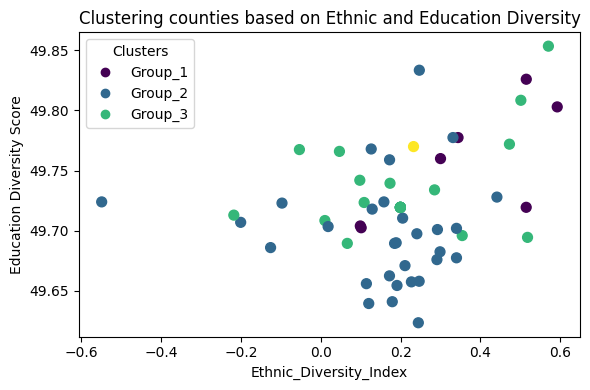

In [83]:
plt.rcParams["figure.figsize"] = [6.00, 4.00]
plt.rcParams["figure.autolayout"] = True

x = df['Ethnic_Diversity_Index']
y = df['Education Diversity Score']
Cluster = df['Clusters_c'].values

fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(x, y, c=Cluster, s=50)

labels1 = ['Group_1','Group_2','Group_3']
handles = scatter.legend_elements()[0]
ax.legend(title="Clusters", handles=handles, labels = labels1)

plt.xlabel("Ethnic_Diversity_Index")
plt.ylabel("Education Diversity Score")
plt.title("Clustering counties based on Ethnic and Education Diversity")
plt.show()

###### From observing both the Clustering Clasifications we can say that K_means has the best outcomes.  